# Comparison of ARIMA and LSTM for time series forecasting

We compare the performance of traditional ARIMA models and Recurrent Neural Networks (LSTMs) for time series forecasting.




To compare the different models, we will monitor their performance for one-step forecasting (without model retraining at each step). 
This simulates the scenario where a time series model is trained and deployed, and we want to monitor its performance over time, while at each time step we collect a new data point. This new data point will augment the training dataset for the next step forecast. 


This monitoring strategy will produce a sequence of one-step forecasts, which can be compared against the true test observations. 

As a measure of performance of the models, we will use the mean absolute percentage error (MAPE). 




In [1]:
# install packages
!pip install statsmodels==0.12.1
!pip install sktime
!pip install pmdarima
!pip install tensorflow

# RESTART RUNTIME AFTER INSTALLATION 
exit()

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Projects/Pollution-time-series

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Projects/Pollution-time-series


# Data preprocessing

## Load data

We will use the [air pollution dataset](https://github.com/jankova/Time-Series-ARIMA-vs-LSTM/pollution_raw.csv). 
The dataset contains hourly measurements of different environmental variables including air pollution, temperature, pressure, dew point or wind direction. 

We will focus on forecasting pollution and consider two different approches:
1. univariate approach using only the time series pollution for training 
2. multivariate approach using all the available variables for training (called exogeneous variables).


In [2]:
# basic imports
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# parse dates
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('pollution_raw.csv', 
                      parse_dates = [['year', 'month', 'day', 'hour']], 
                      index_col=0, 
                      date_parser=parse)

dataset.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
year_month_day_hour,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


The list of variables in the dataset:
1. No: row number
2. year: year of data in this row
3. month: month of data in this row
4. day: day of data in this row
5. hour: hour of data in this row
6. pm2.5: PM2.5 concentration
7. DEWP: Dew Point
8. TEMP: Temperature
9. PRES: Pressure
10. cbwd: Combined wind direction
11. Iws: Cumulated wind speed
12. Is: Cumulated hours of snow
13. Ir: Cumulated hours of rain

## Basic preprocessing and missing data

In [ ]:
dataset.drop('No', axis=1, inplace=True)
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
dataset.info()

# fill all NA values with forward fill
dataset['pollution'].fillna(method = "ffill", inplace=True)

# drop the first 24 hours
dataset = dataset[24:]

# save to file
dataset.to_csv('pollution.csv')

# encoding categorical variables
wnd_dir_enc = pd.get_dummies(dataset["wnd_dir"], prefix="wnd_dir", prefix_sep='_', drop_first = True)

dataset = pd.concat([dataset.drop("wnd_dir", axis = 1), wnd_dir_enc], axis = 1)
dataset.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  41757 non-null  float64
 1   dew        43824 non-null  int64  
 2   temp       43824 non-null  float64
 3   press      43824 non-null  float64
 4   wnd_dir    43824 non-null  object 
 5   wnd_spd    43824 non-null  float64
 6   snow       43824 non-null  int64  
 7   rain       43824 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


,pollution,dew,temp,press,wnd_spd,snow,rain,wnd_dir_NW,wnd_dir_SE,wnd_dir_cv
date,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,1,0


## Exploratory plots

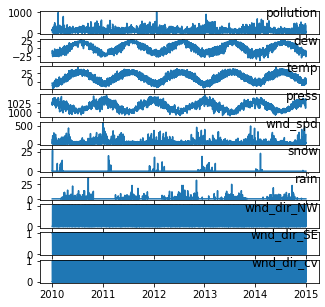

In [ ]:
import numpy as np

# specify columns to plot
cols = dataset.columns

# plot each column
plt.figure(figsize = (5,5))
for i, col in enumerate(cols):
	plt.subplot(len(cols), 1, i+1)
	plt.plot(dataset[col])
	plt.title(dataset.columns[i], y=0.5, loc='right')

plt.show()

## Create train data

In [ ]:
dataset.index = pd.date_range(start=dataset.index[0], 
                              end=dataset.index[-1], 
                              freq = 'H')


# take a subset of the full dataset
n_train = 3000
dataset_train = dataset.iloc[:n_train, :]


# ARIMA

## ARIMA exploratory analysis 


In [ ]:
# test for stationarity: Augmented Dickey-Fuller test (unit root test)

from statsmodels.tsa.stattools import adfuller, kpss

res_adf = adfuller(dataset["pollution"])
res_adf

print(f"p-value ADF: {res_adf[1]}")

# H0: unit root is present; test rejects non-stationarity

# KPSS test for stationarity

statistic, p_value, n_lags, critical_values = kpss(dataset["pollution"])

print(f"p-value KPSS: {p_value}")

# H0: stationary; test does not reject stationarity

p-value ADF: 0.0
p-value KPSS: 0.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1850: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


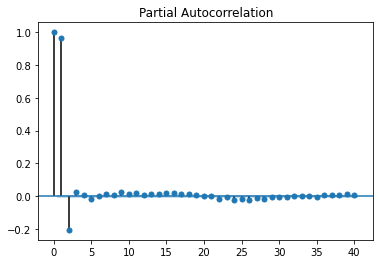

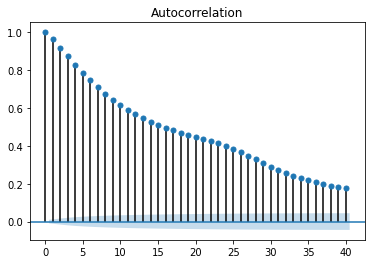

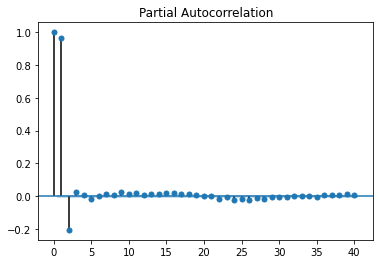

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(dataset["pollution"], lags=40)
plot_pacf(dataset["pollution"], lags=40)


In [ ]:
# train ARIMA

from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns

p = 2
q = 2
d = 0
arima = ARIMA(dataset_train["pollution"], order = (p, q, d))
model_fit = arima.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                 3000
Model:                 ARIMA(5, 2, 0)   Log Likelihood              -14811.772
Date:                Mon, 14 Mar 2022   AIC                          29635.545
Time:                        20:41:17   BIC                          29671.579
Sample:                    01-02-2010   HQIC                         29648.507
                         - 05-06-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5350      0.004   -148.758      0.000      -0.542      -0.528
ar.L2         -0.5540      0.004   -129.239      0.000      -0.562      -0.546
ar.L3         -0.5302      0.006    -87.046      0.0

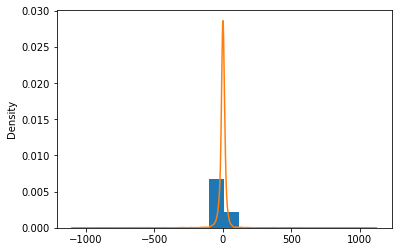

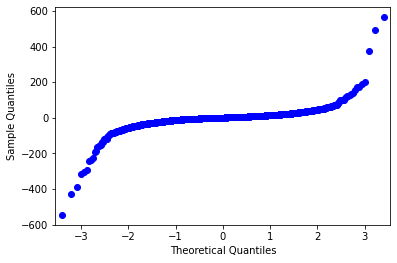

In [ ]:
# residual check

plt.hist(model_fit.resid, density = True)
model_fit.resid.plot(kind='kde')
import statsmodels.api as sm
sm.qqplot(model_fit.resid)
plt.show()
#plot_acf(model_fit.resid)

## SARIMAX

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [ ]:
# defining exogeneous variables
X_exo = dataset_train.drop(["pollution"], axis = 1)

y_train, y_test, X_train, X_test = temporal_train_test_split(dataset_train["pollution"], 
                                                             X_exo, 
                                                             test_size=.1)


In [ ]:
import statsmodels.api as sm

order = (2,0,2) # obtained from autoARIMA

sar = sm.tsa.statespace.SARIMAX(endog = y_train,
                                order = order) 

res = sar.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                 2700
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13166.546
Date:                Mon, 14 Mar 2022   AIC                          26343.093
Time:                        21:14:53   BIC                          26372.598
Sample:                    01-02-2010   HQIC                         26353.763
                         - 04-24-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7745      0.015    119.593      0.000       1.745       1.804
ar.L2         -0.7761      0.014    -54.170      0.000      -0.804      -0.748
ma.L1         -0.5836      0.015    -37.900      0.0

In [ ]:
# fixed origin forecast

preds_arima = res.predict(start = y_test.index[0], end = y_test.index[-1], dynamic=True)
preds_arima.shape

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


(300,)

In [ ]:
# rolling one-step forecast
# use a trick here - define a model on full dataset but then make predictions only 
# using the parameters from 'res.params' model

mod = sm.tsa.statespace.SARIMAX(dataset_train["pollution"], order=order)
res_roll = mod.filter(res.params)
preds_arima_roll = res_roll.predict()
preds_arima_roll = preds_arima_roll[y_test.index]


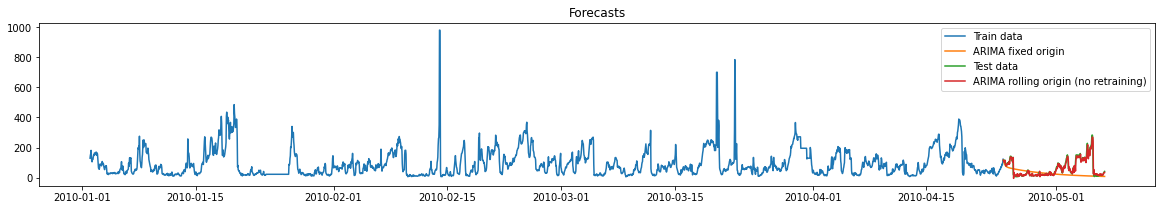

In [ ]:
# Forecast plots
plt.figure(figsize = (20, 3))
plt.plot(y_train, label = "Train data")
plt.plot(preds_arima, label = "ARIMA fixed origin")
plt.plot(y_test, label = "Test data")
plt.plot(preds_arima_roll, label = "ARIMA rolling origin (no retraining)")
plt.title("Forecasts")
plt.legend()


In [ ]:
# Comparison of MAPE errors
print(f"Fixed origin ARIMA: {evaluate_MAPE(preds_arima, y_test)}")
print(f"Rolling origin ARIMA (no retraining): {evaluate_MAPE(preds_arima_roll, y_test)}")

Fixed origin ARIMA: 3.113156670682303
Rolling origin ARIMA (no retraining): 0.22800903026425015


## SARIMAX with exogeneous variables

In [ ]:
import statsmodels.api as sm

order = (2,0,2)

sar = sm.tsa.statespace.SARIMAX(endog = y_train, exog = X_train,
                                order = order)

res_arima_exo = sar.fit(disp=False)
print(res_arima_exo.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


                               SARIMAX Results                                
Dep. Variable:              pollution   No. Observations:                 2700
Model:               SARIMAX(2, 0, 2)   Log Likelihood              -13165.218
Date:                Mon, 14 Mar 2022   AIC                          26358.435
Time:                        21:15:12   BIC                          26441.049
Sample:                    01-02-2010   HQIC                         26388.311
                         - 04-24-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dew            1.7134      0.378      4.530      0.000       0.972       2.455
temp          -0.3337      0.401     -0.832      0.405      -1.119       0.452
press          0.0995      0.017      5.729      0.0

In [ ]:
# fixed origin forecast
preds_arima_exo = res_arima_exo.predict(start = y_test.index[0], end = y_test.index[-1], 
                                        dynamic = True, 
                                        exog = X_test)
preds_arima_exo.shape


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


(300,)

In [ ]:
# rolling origin forecast (no retraining)

mod = sm.tsa.statespace.SARIMAX(endog = dataset_train["pollution"], 
                                exog = dataset_train.drop("pollution", axis = 1), order=order)
res_roll_exo = mod.filter(res_arima_exo.params)
preds_arima_roll_exo = res_roll_exo.predict()
preds_arima_roll_exo = preds_arima_roll_exo[y_test.index]


## Evaluation of ARIMA models

In [ ]:
# metrics for evaluating prediction error
# Mean Absolute Percentage Error

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

def evaluate_MAPE(preds, y_test):
    return mean_absolute_percentage_error(preds, y_test)


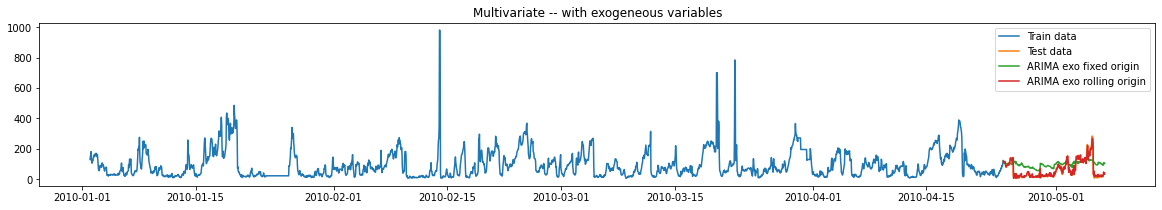

In [ ]:
plt.figure(figsize = (20, 3))
plt.plot(y_train, label = "Train data")
plt.plot(y_test, label = "Test data")
plt.plot(preds_arima_exo, label = "ARIMA exo fixed origin")
plt.plot(preds_arima_roll_exo, label = "ARIMA exo rolling origin")
plt.title("Multivariate -- with exogeneous variables")
plt.legend()

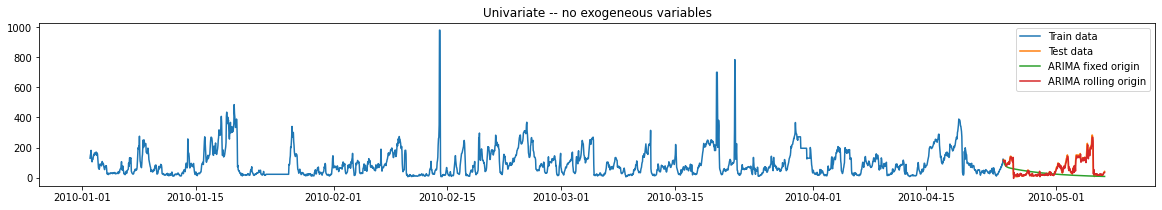

In [ ]:
plt.figure(figsize = (20, 3))
plt.plot(y_train, label = "Train data")
plt.plot(y_test, label = "Test data")
plt.plot(preds_arima, label = "ARIMA fixed origin")
plt.plot(preds_arima_roll, label = "ARIMA rolling origin")
plt.title("Univariate -- no exogeneous variables")

plt.legend()


In [ ]:
# comparison of MAPE errors

print(f"Fixed origin ARIMA: {evaluate_MAPE(preds_arima, y_test)}")
print(f"Fixed origin ARIMA exo: {evaluate_MAPE(preds_arima_exo, y_test)}")
print(f"Rolling origin ARIMA: {evaluate_MAPE(preds_arima_roll, y_test)}")
print(f"Rolling origin ARIMA exo: {evaluate_MAPE(preds_arima_roll_exo, y_test)}")

Fixed origin ARIMA: 3.113156670682303
Fixed origin ARIMA exo: 0.5603317810518187
Rolling origin ARIMA: 0.22800903026425015
Rolling origin ARIMA exo: 0.2240123266300038


# LSTM and machine learning methods



## Conversion to supervised learning framework

To train LSTM, we convert the time series data to a supervised learning dataframe using a slicing window. 
In each supervised example, the features are the variable values at previous 'n_in' time steps and the response variable is pollution at the current time step. 


In [ ]:
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Transform a collection of time series into a dataframe suitable for supervised learning.
        data: a dataframe containing a number of time series
        n_in: the number of lags to consider 
        n_out: the dimension of the output
        dropnan: True if drop NaN from final dataframe
    '''
    n_vars = data.shape[1]
    df = data.copy()

    cols, names = list(), list()
   
	  # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'{var_name}_t-{i}' for var_name in data.columns]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        names += [f'{var_name}_t+{i}' for var_name in data.columns]

	  # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

	  # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [ ]:
## scaling

data = dataset_train.copy()

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1, 2, 3, 4, 7))
scaled = scaler.fit_transform(data)
scaled = pd.DataFrame(scaled, columns = data.columns)

n_features = scaled.shape[1]
n_features

n_in = 7

In [ ]:
# split into train and test

scaled_train, scaled_test = temporal_train_test_split(scaled, test_size = 0.1)


In [ ]:
# MULTIVARIATE MODELING 
# -- prepare data to perform 

# reframing train and test separately

response_name = "pollution"

scaled_train, scaled_test = temporal_train_test_split(scaled, test_size = 0.1)

reframed_train = series_to_supervised(scaled_train, n_in = n_in, n_out = 1, dropnan=True)
reframed_test = series_to_supervised(scaled_test, n_in = n_in, n_out = 1, dropnan=True)

drop_vars = [f'{var_name}_t+0' for var_name in data.columns]
drop_vars.remove(f'{response_name}_t+0')

# drop columns we don't want to predict
df_full_train = reframed_train.drop(drop_vars, axis = 1)
df_full_test = reframed_test.drop(drop_vars, axis = 1)

X_test = df_full_test.drop([f"{response_name}_t+0"], axis = 1)
y_test_n = df_full_test[f"{response_name}_t+0"]

X_train = df_full_train.drop([f"{response_name}_t+0"], axis = 1)
y_train_n = df_full_train[f"{response_name}_t+0"]


In [ ]:
# UNIVARIATE MODELING
#  -- only pollution time series used, no exogeneous variables

# reframing train and test separately

scaled_train_uni, scaled_test_uni = temporal_train_test_split(scaled[["pollution"]], test_size = 0.1)

reframed_train_uni = series_to_supervised(scaled_train_uni, n_in = n_in, n_out = 1, dropnan=True)
reframed_test_uni = series_to_supervised(scaled_test_uni, n_in = n_in, n_out = 1, dropnan=True)

X_test_uni = reframed_test_uni.drop([f"{response_name}_t+0"], axis = 1)
y_test_n_uni = reframed_test_uni[f"{response_name}_t+0"]

X_train_uni = reframed_train_uni.drop([f"{response_name}_t+0"], axis = 1)
y_train_n_uni = reframed_train_uni[f"{response_name}_t+0"]

## Classical machine learning

In [ ]:
# train on univariate time series only (i.e. using pollution only)

import numpy as np
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train_uni, y_train_n_uni)
y_pred_rf_uni = rf.predict(X_test_uni)

def rescale(y_pred):
    '''
    Auxiliary function for rescaling predictions to original scale.
    '''
    temp_pred = np.concatenate((np.array(y_pred).reshape(-1,1), 
                            np.ones((y_test_n.shape[0], n_features - 1))), axis = 1)
    y_pred_rescaled = scaler.inverse_transform(temp_pred)
    y_pred_rescaled = pd.Series(y_pred_rescaled[:,0], index = y_test_n.index)

    return y_pred_rescaled

y_pred_rf_rescaled_uni = rescale(y_pred_rf_uni)# pd.Series(y_pred_rf_rescaled_uni[:,0], index = y_test_n_uni.index)



In [ ]:
# train with exogeneous variables

import numpy as np
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train_n)
y_pred_rf = rf.predict(X_test)
y_pred_rf_rescaled = rescale(y_pred_rf) #pd.Series(y_pred_rf_rescaled[:,0], index = y_test_n.index)



## LSTM

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [ ]:
# reshape data to 3D-shape expected by LSTMs: [samples, timesteps, features]
import numpy as np

X_train_scaled_3d = np.array(X_train).reshape((X_train.shape[0], n_in, n_features))
print(X_train_scaled_3d.shape)

X_test_scaled_3d = np.array(X_test).reshape((X_test.shape[0], n_in, n_features))
print(X_test_scaled_3d.shape)

(2693, 7, 10)
(293, 7, 10)


Epoch 1/100
38/38 - 5s - loss: 0.0612 - val_loss: 0.0360 - 5s/epoch - 122ms/step
Epoch 2/100
38/38 - 0s - loss: 0.0456 - val_loss: 0.0361 - 456ms/epoch - 12ms/step
Epoch 3/100
38/38 - 0s - loss: 0.0441 - val_loss: 0.0310 - 472ms/epoch - 12ms/step
Epoch 4/100
38/38 - 0s - loss: 0.0407 - val_loss: 0.0279 - 452ms/epoch - 12ms/step
Epoch 5/100
38/38 - 0s - loss: 0.0385 - val_loss: 0.0256 - 476ms/epoch - 13ms/step
Epoch 6/100
38/38 - 0s - loss: 0.0361 - val_loss: 0.0245 - 450ms/epoch - 12ms/step
Epoch 7/100
38/38 - 0s - loss: 0.0353 - val_loss: 0.0236 - 478ms/epoch - 13ms/step
Epoch 8/100
38/38 - 0s - loss: 0.0341 - val_loss: 0.0246 - 446ms/epoch - 12ms/step
Epoch 9/100
38/38 - 0s - loss: 0.0336 - val_loss: 0.0228 - 483ms/epoch - 13ms/step
Epoch 10/100
38/38 - 0s - loss: 0.0336 - val_loss: 0.0231 - 438ms/epoch - 12ms/step
Epoch 11/100
38/38 - 0s - loss: 0.0334 - val_loss: 0.0235 - 460ms/epoch - 12ms/step
Epoch 12/100
38/38 - 0s - loss: 0.0327 - val_loss: 0.0228 - 460ms/epoch - 12ms/step
Epo

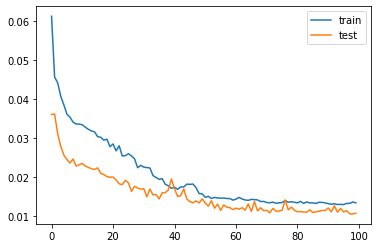

In [ ]:
# network architecture
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, 
                    input_shape=(X_train_scaled_3d.shape[1], X_train_scaled_3d.shape[2])))
model_lstm.add(LSTM(50, activation='relu'))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mae', optimizer='adam')

# training
history = model_lstm.fit(X_train_scaled_3d, y_train_n, 
                    epochs=100, 
                    batch_size=72, 
                    validation_data=(X_test_scaled_3d, y_test_n), 
                    verbose=2, 
                    shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# compute predictions
preds_lstm = model_lstm.predict(X_test_scaled_3d).flatten()

# rescale predictions to original scale
preds_lstm_rescaled = rescale(preds_lstm)

# rescale y_test to original scale (for latter plotting)
y_test_rescaled = rescale(y_test_n)



# Comparison of models

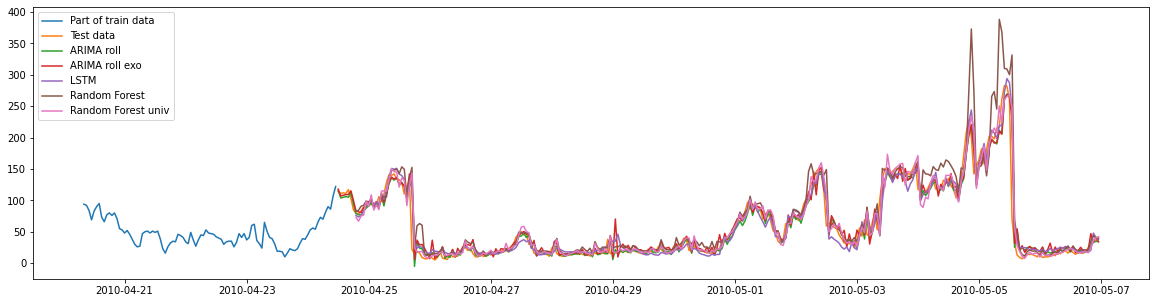

In [ ]:
# plot LSTM predictions along with ARIMA and Random Forest predictions

plt.figure(figsize = (20, 5))
plt.plot(y_train[-100:], label = "Part of train data")
plt.plot(y_test, label = "Test data")

plt.plot(pd.Series(preds_arima_roll.values, 
                   index = y_test.index), label = "ARIMA roll")
plt.plot(pd.Series(preds_arima_roll_exo.values, 
                   index = y_test.index), label = "ARIMA roll exo")

plt.plot(pd.Series(preds_lstm_rescaled.values, 
                   index = y_test.index[n_in:]), label = "LSTM")

plt.plot(pd.Series(y_pred_rf_rescaled.values, 
                   index = y_test.index[n_in:]), label = "Random Forest")

plt.plot(pd.Series(y_pred_rf_rescaled_uni.values, 
                   index = y_test.index[n_in:]), label = "Random Forest univ")

plt.legend()

MAPE scores
ARIMA rolling: 0.23176417373560698
ARIMA Exo rolling: 0.22783299376089222
Random Forest: 0.22353759261748127
Random Forest uni: 0.19091834766504162
LSTM: 0.24779939276610954




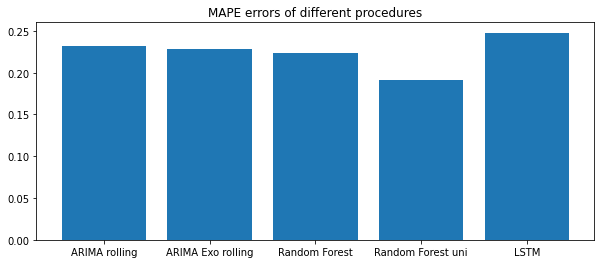

In [ ]:
# compare MAE score for different methods

print("MAPE scores")

MAPES = {}

#MAPES["AUTOArima"] = evaluate_MAPE(preds_auto.values[4:], y_test_rescaled)
#MAPES["AUTOArima Exo"] = evaluate_MAPE(preds_auto_exo.values[4:], y_test_rescaled)
MAPES["ARIMA rolling"] = evaluate_MAPE(preds_arima_roll.values[n_in:], y_test_rescaled)
MAPES["ARIMA Exo rolling"] = evaluate_MAPE(preds_arima_roll_exo.values[n_in:], y_test_rescaled)
MAPES["Random Forest"] = evaluate_MAPE(y_pred_rf_rescaled, y_test_rescaled)
MAPES["Random Forest uni"] = evaluate_MAPE(y_pred_rf_rescaled_uni, y_test_rescaled)
MAPES["LSTM"] = evaluate_MAPE(preds_lstm_rescaled, y_test_rescaled)
#MAPES["CNN"] = evaluate_MAPE(preds_cnn_rescaled, y_test_n)

for item in MAPES:
    print(f"{item}: {MAPES[item]}")

print('\n')

plt.figure(figsize = (10, 4))
plt.title("MAPE errors of different procedures")
plt.bar(*zip(*MAPES.items()))
plt.show()